<img src="https://www.gov.br/cbpf/pt-br/nucleo-de-comunicacao-social/cbpf.png"  width="500" />

<font size="5"> Search For Transients in Dark Energy Survey dataset with a RandomForest Classifier Tutorial.
    
<font size="2">
This notebook introduces essential Python libraries for data analysis, including NumPy, Pandas, SciPy, and Matplotlib. We will perform basic operations on a tabular dataset, identify problematic features, clean the dataset, and apply physically motivated cuts.

    
---
  
    This code was developed by Phelipe Darc.

---

<a href="phelipedarc.github.io">phelipedarc.github</a>
    
**Contact:** phelipedarc@cbpf.br</font>

<font size="2">

Please do not remove this disclaimer.</font>

# Introdução:
### Real Transient:

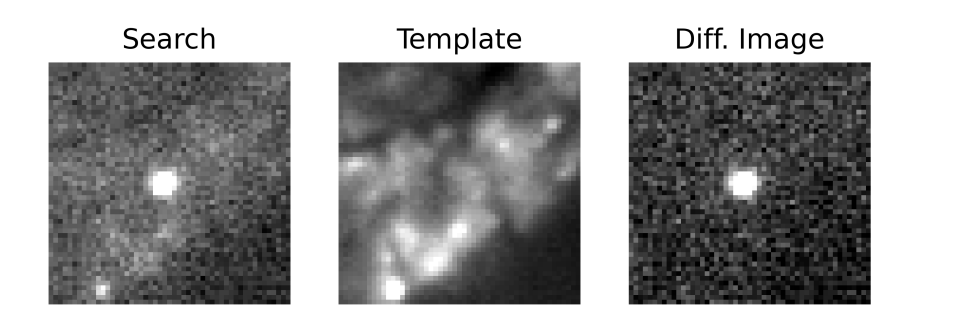


### Artifact - Bad Subtraction:

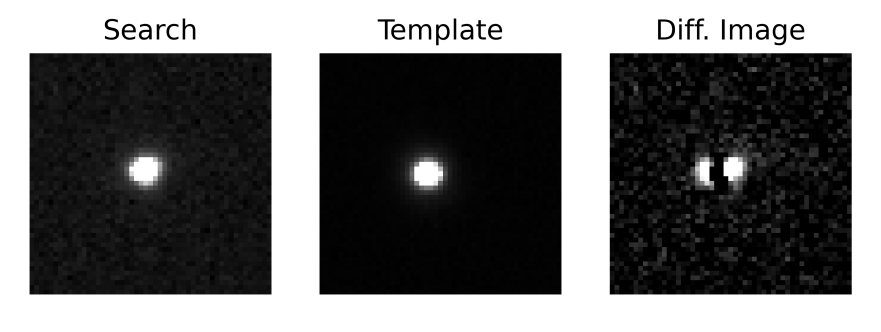

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd  # Biblioteca para manipulação e análise de dados tabulares (DataFrames).
from astropy.table import Table  # Ferramenta para manipular tabelas astronômicas (Astropy).
import matplotlib.pyplot as plt  # Biblioteca para criar gráficos e visualizações.
import h5py  # Biblioteca para manipular arquivos no formato HDF5.
import numpy as np  # Biblioteca para computação numérica e manipulação de arrays.
import glob  # Módulo para trabalhar com caminhos e buscar arquivos em diretórios.
from astropy.io import fits  # Ferramenta para ler e escrever arquivos no formato FITS, usado em dados astronômicos.
from astropy.table import Table  # Outra ferramenta da biblioteca Astropy para tabelas astronômicas (repetida, pode ser removida se desnecessária).
import os  # Biblioteca para interagir com o sistema operacional (manipular arquivos, diretórios, etc.).
import time  # Biblioteca para medir o tempo de execução ou trabalhar com horários e datas.


### Abrindo o Dataset
***

In [2]:
#glob.glob('/tf/astrodados2/Autoscan-Dataset/autoscan_dataset/SNWG/Archive/2013/Y1/*/*/*.fits')

In [3]:
# Definindo o caminho para o diretório onde os arquivos do conjunto de dados estão armazenados
path = "/tf/astrodados2/Autoscan-Dataset/"

# Usando a função os.listdir() para listar todos os arquivos e subdiretórios presentes no caminho especificado
dirs = os.listdir(path)

# Exibindo a lista de arquivos e diretórios encontrados no console
print(dirs)


['autoscan_dataset', 'previsores_NORMtransientsartifacts.csv', '.ipynb_checkpoints', 'NORMtransientsartifacts.npy', 'previsores_NORMtransientsartifacts.npy']


In [4]:
y_data = pd.read_csv(path+"previsores_NORMtransientsartifacts.csv")
#y_data = np.load(path+"previsores_NORMtransientsartifacts.npy",allow_pickle=True)
#x_data = np.float32(np.load(path+"NORMtransientsartifacts.npy",allow_pickle=True))

#0 - Artefato
#1 - Transient

In [7]:
'''
the feature diffsum measures the significance
of the detection by summing the pixel values in the center of the diff image; the feature
colmeds, indicating the CCD used for the detection, is designed to identify artifacts specific to a CCD, 
like bad rows/columns of pixels; the feature Signal-to-noise ratio, could
be used to find noise stamps.

'''
y_data.keys()


Index(['Unnamed: 0', 'ID', 'OBJECT_TYPE', 'AMP', 'A_IMAGE', 'A_REF', 'BAND',
       'B_IMAGE', 'B_REF', 'CCDID', 'COLMEDS', 'DIFFSUMRN', 'ELLIPTICITY',
       'FLAGS', 'FLUX_RATIO', 'GAUSS', 'GFLUX', 'L1', 'LACOSMIC', 'MAG',
       'MAGDIFF', 'MAGLIM', 'MAG_FROM_LIMIT', 'MAG_REF', 'MAG_REF_ERR',
       'MASKFRAC', 'MIN_DISTANCE_TO_EDGE_IN_NEW', 'N2SIG3', 'N2SIG3SHIFT',
       'N2SIG5', 'N2SIG5SHIFT', 'N3SIG3', 'N3SIG3SHIFT', 'N3SIG5',
       'N3SIG5SHIFT', 'NN_DIST_RENORM', 'NUMNEGRN', 'SCALE', 'SNR',
       'SPREADERR_MODEL', 'SPREAD_MODEL', '0'],
      dtype='object')

## Lidando com variavéis categóricas:

***Observação: As bandas ('BAND') são valores categóricos, então precisamos transformá-las em um formato numérico. Neste caso, usamos codificação ordinal (ordinal encoding), mas também seria possível usar One Hot Encoding dependendo do objetivo***

<img src="https://miro.medium.com/v2/resize:fit:1200/0*T5jaa2othYfXZX9W."  width="500" />

In [8]:
#Encoding the Bands to numbers:
# Exibindo a contagem de ocorrências de cada valor único na coluna 'BAND'
print(y_data['BAND'].value_counts())

# Transformando a coluna 'BAND' em uma variável categórica
y_data['BAND'] = y_data['BAND'].astype('category')

# Aplicando codificação ordinal para transformar as categorias em números
# Cada categoria será substituída por um código numérico único
y_data['BAND'] = y_data['BAND'].cat.codes

# Exibindo novamente a contagem de ocorrências, agora com os valores codificados
print(y_data['BAND'].value_counts())

BAND
i    4323
z    4006
r    3886
g    2692
Name: count, dtype: int64
BAND
1    4323
3    4006
2    3886
0    2692
Name: count, dtype: int64


<div style="color:red; font-weight:bold; font-size:20px;">
#### [Task] Faça um histograma das bandas observadas neste dataset:

<Axes: >

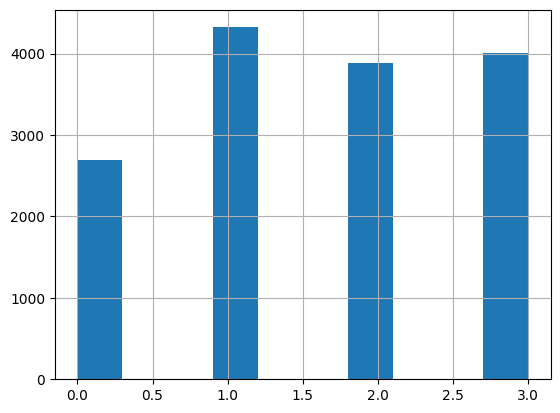

In [9]:
y_data['BAND'].hist()

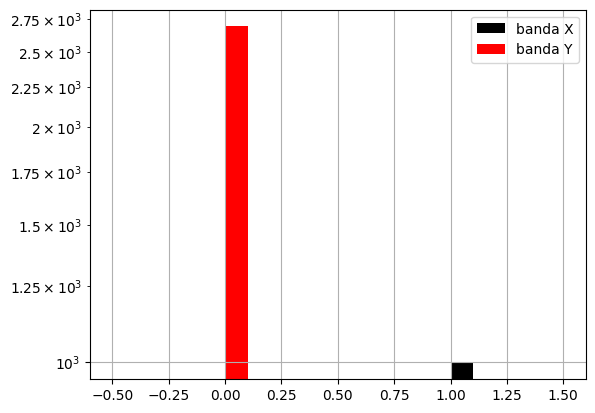

In [10]:
plt.hist(y_data[(y_data['BAND']==1) & (y_data['MAG']<22)]['BAND'],label='banda X', color='black', log=True)
plt.hist(y_data[y_data['BAND']==0]['BAND'],label='banda Y', color='red',log=True)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
y_data

,Unnamed: 0,ID,OBJECT_TYPE,AMP,A_IMAGE,A_REF,BAND,B_IMAGE,B_REF,CCDID,...,N3SIG3SHIFT,N3SIG5,N3SIG5SHIFT,NN_DIST_RENORM,NUMNEGRN,SCALE,SNR,SPREADERR_MODEL,SPREAD_MODEL,0
0,8900,6960247,0,0.531837,0.950,2.555519,0,0.468,2.509721,52,...,-10,3,-22,0.924680,15,2.083950,4.708784,0.004655,-0.002805,6960247
1,13232,6960249,1,0.495848,0.577,5.897173,0,0.289,4.086975,52,...,-21,2,-42,0.619498,20,2.143211,4.152969,0.005290,0.004733,6960249
2,12239,6960261,1,1.006386,1.897,2.699702,0,1.191,2.569838,52,...,-10,8,-22,0.737011,18,1.807541,9.160797,0.003462,-0.019242,6960261
3,11566,6961061,1,0.853074,1.204,2.627933,0,0.977,2.554036,28,...,-10,4,-20,0.977689,19,1.538837,6.044542,0.004819,-0.016572,6961061
4,8707,6961294,0,0.859011,2.132,NaN,0,1.870,NaN,36,...,10,0,10,NaN,7,2.505073,15.869987,0.001825,-0.002269,6961294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14902,11087,8270367,1,0.763482,1.145,3.903739,1,0.902,2.656357,6,...,-20,0,-43,0.556593,29,1.468949,5.596974,0.007175,-0.036013,8270367
14903,11042,8270547,1,0.470567,0.578,6.948134,1,0.333,5.000814,44,...,-24,1,-44,0.635657,23,1.668448,3.517759,0.009927,-0.021436,8270547
14904,324,8270552,1,0.740089,1.477,4.087810,1,1.159,2.496189,44,...,-18,1,-37,0.133402,19,2.107939,8.828901,0.004344,-0.007316,8270552
14905,7498,8270673,0,0.870918,2.527,3.152924,1,2.271,1.784108,47,...,11,0,5,1.796943,2,2.345171,43.833141,0.000859,-0.000407,8270673


In [87]:
#Todos os Features e informações que temos sobre as imagens
y_data.columns

Index(['Unnamed: 0', 'ID', 'OBJECT_TYPE', 'AMP', 'A_IMAGE', 'A_REF', 'BAND',
       'B_IMAGE', 'B_REF', 'CCDID', 'COLMEDS', 'DIFFSUMRN', 'ELLIPTICITY',
       'FLAGS', 'FLUX_RATIO', 'GAUSS', 'GFLUX', 'L1', 'LACOSMIC', 'MAG',
       'MAGDIFF', 'MAGLIM', 'MAG_FROM_LIMIT', 'MAG_REF', 'MAG_REF_ERR',
       'MASKFRAC', 'MIN_DISTANCE_TO_EDGE_IN_NEW', 'N2SIG3', 'N2SIG3SHIFT',
       'N2SIG5', 'N2SIG5SHIFT', 'N3SIG3', 'N3SIG3SHIFT', 'N3SIG5',
       'N3SIG5SHIFT', 'NN_DIST_RENORM', 'NUMNEGRN', 'SCALE', 'SNR',
       'SPREADERR_MODEL', 'SPREAD_MODEL', '0'],
      dtype='object')


## Selecionando os Features:
***

Now we select the features that will be used in the Random Forest. 

As a physicist you know which features are probably important but if you dont, you can use the PCA to determine which are the most correlated features to feed the model.

In [12]:
# Selecione os features que você acha que ajudarão no modelo de IA
x_features=y_data[['MAGDIFF','SPREADERR_MODEL','N2SIG3','N2SIG5','N3SIG3','N3SIG5','MAG_REF_ERR','SNR','COLMEDS','NN_DIST_RENORM','ELLIPTICITY','AMP','CCDID','MAG','B_IMAGE','MAG_REF','DIFFSUMRN','A_REF','MASKFRAC','MAGLIM','BAND','N3SIG3SHIFT']]

In [18]:
x_features

,MAGDIFF,SPREADERR_MODEL,N2SIG3,N2SIG5,N3SIG3,N3SIG5,MAG_REF_ERR,SNR,COLMEDS,NN_DIST_RENORM,...,CCDID,MAG,B_IMAGE,MAG_REF,DIFFSUMRN,A_REF,MASKFRAC,MAGLIM,BAND,N3SIG3SHIFT
0,-4.173300,0.004655,1,5,0,3,0.0008,4.708784,0.049928,0.924680,...,52,23.033300,0.468,18.860001,56.958462,2.555519,0.145713,0,0,-10
1,-4.342501,0.005290,2,5,1,2,0.0032,4.152969,0.113290,0.619498,...,52,24.121901,0.289,19.779400,31.114668,5.897173,0.000000,0,0,-21
2,-2.623100,0.003462,3,9,3,8,0.0019,9.160797,0.040533,0.737011,...,52,22.355000,1.191,19.731899,91.364334,2.699702,0.264129,0,0,-10
3,-3.433300,0.004819,3,8,2,4,0.0022,6.044542,0.041701,0.977689,...,28,23.303699,0.977,19.870399,45.600044,2.627933,0.000000,0,0,-10
4,2.837700,0.001825,0,0,0,0,NaN,15.869987,0.080464,NaN,...,36,22.308701,1.870,NaN,88.475769,NaN,0.000000,1,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14902,-5.503700,0.007175,3,4,0,0,0.0007,5.596974,0.115951,0.556593,...,6,24.191200,0.902,18.687500,15.674376,3.903739,0.000000,0,1,-20
14903,-4.939300,0.009927,1,3,0,1,0.0035,3.517759,0.091304,0.635657,...,44,24.595900,0.333,19.656601,10.219183,6.948134,0.000000,0,1,-24
14904,-3.345099,0.004344,0,3,0,1,0.0038,8.828901,0.127140,0.133402,...,44,23.636999,1.159,20.291901,37.730293,4.087810,0.000000,0,1,-18
14905,0.754800,0.000859,0,0,0,0,0.0203,43.833141,0.042321,1.796943,...,47,21.872900,2.271,22.627701,167.809174,3.152924,0.000000,0,1,11


In [23]:
features_test=y_data[[ 'AMP', 'A_REF', 'BAND',
       'B_IMAGE', 'B_REF', 'CCDID', 'COLMEDS', 'DIFFSUMRN', 'ELLIPTICITY',
       'FLAGS', 'FLUX_RATIO', 'GAUSS', 'L1', 'LACOSMIC', 'MAG',
       'MAGDIFF', 'MAGLIM', 'MAG_FROM_LIMIT', 'MAG_REF', 'MAG_REF_ERR',
       'MASKFRAC', 'MIN_DISTANCE_TO_EDGE_IN_NEW', 'N2SIG3', 'N2SIG3SHIFT',
       'N2SIG5', 'N2SIG5SHIFT', 'N3SIG3', 'N3SIG3SHIFT', 'N3SIG5',
       'N3SIG5SHIFT', 'NN_DIST_RENORM', 'NUMNEGRN', 'SCALE', 'SNR',
       'SPREADERR_MODEL', 'SPREAD_MODEL']]
# features_test = y_data[['MAGDIFF','SPREADERR_MODEL','N2SIG3','N2SIG5','N3SIG3','N3SIG5','MAG_REF_ERR','SNR','COLMEDS',
#                  'NN_DIST_RENORM','ELLIPTICITY','AMP','CCDID','MAG','B_IMAGE','MAG_REF','DIFFSUMRN','A_REF',
#                  'MASKFRAC','MAGLIM','BAND','N3SIG3SHIFT']]

<div style="color:red; font-weight:bold; font-size:20px;">
#### [Task] Faça uma análise de quais features vocês esperam que tenham o maior impacto na hora de indentificar um transiente e remover um artefato:

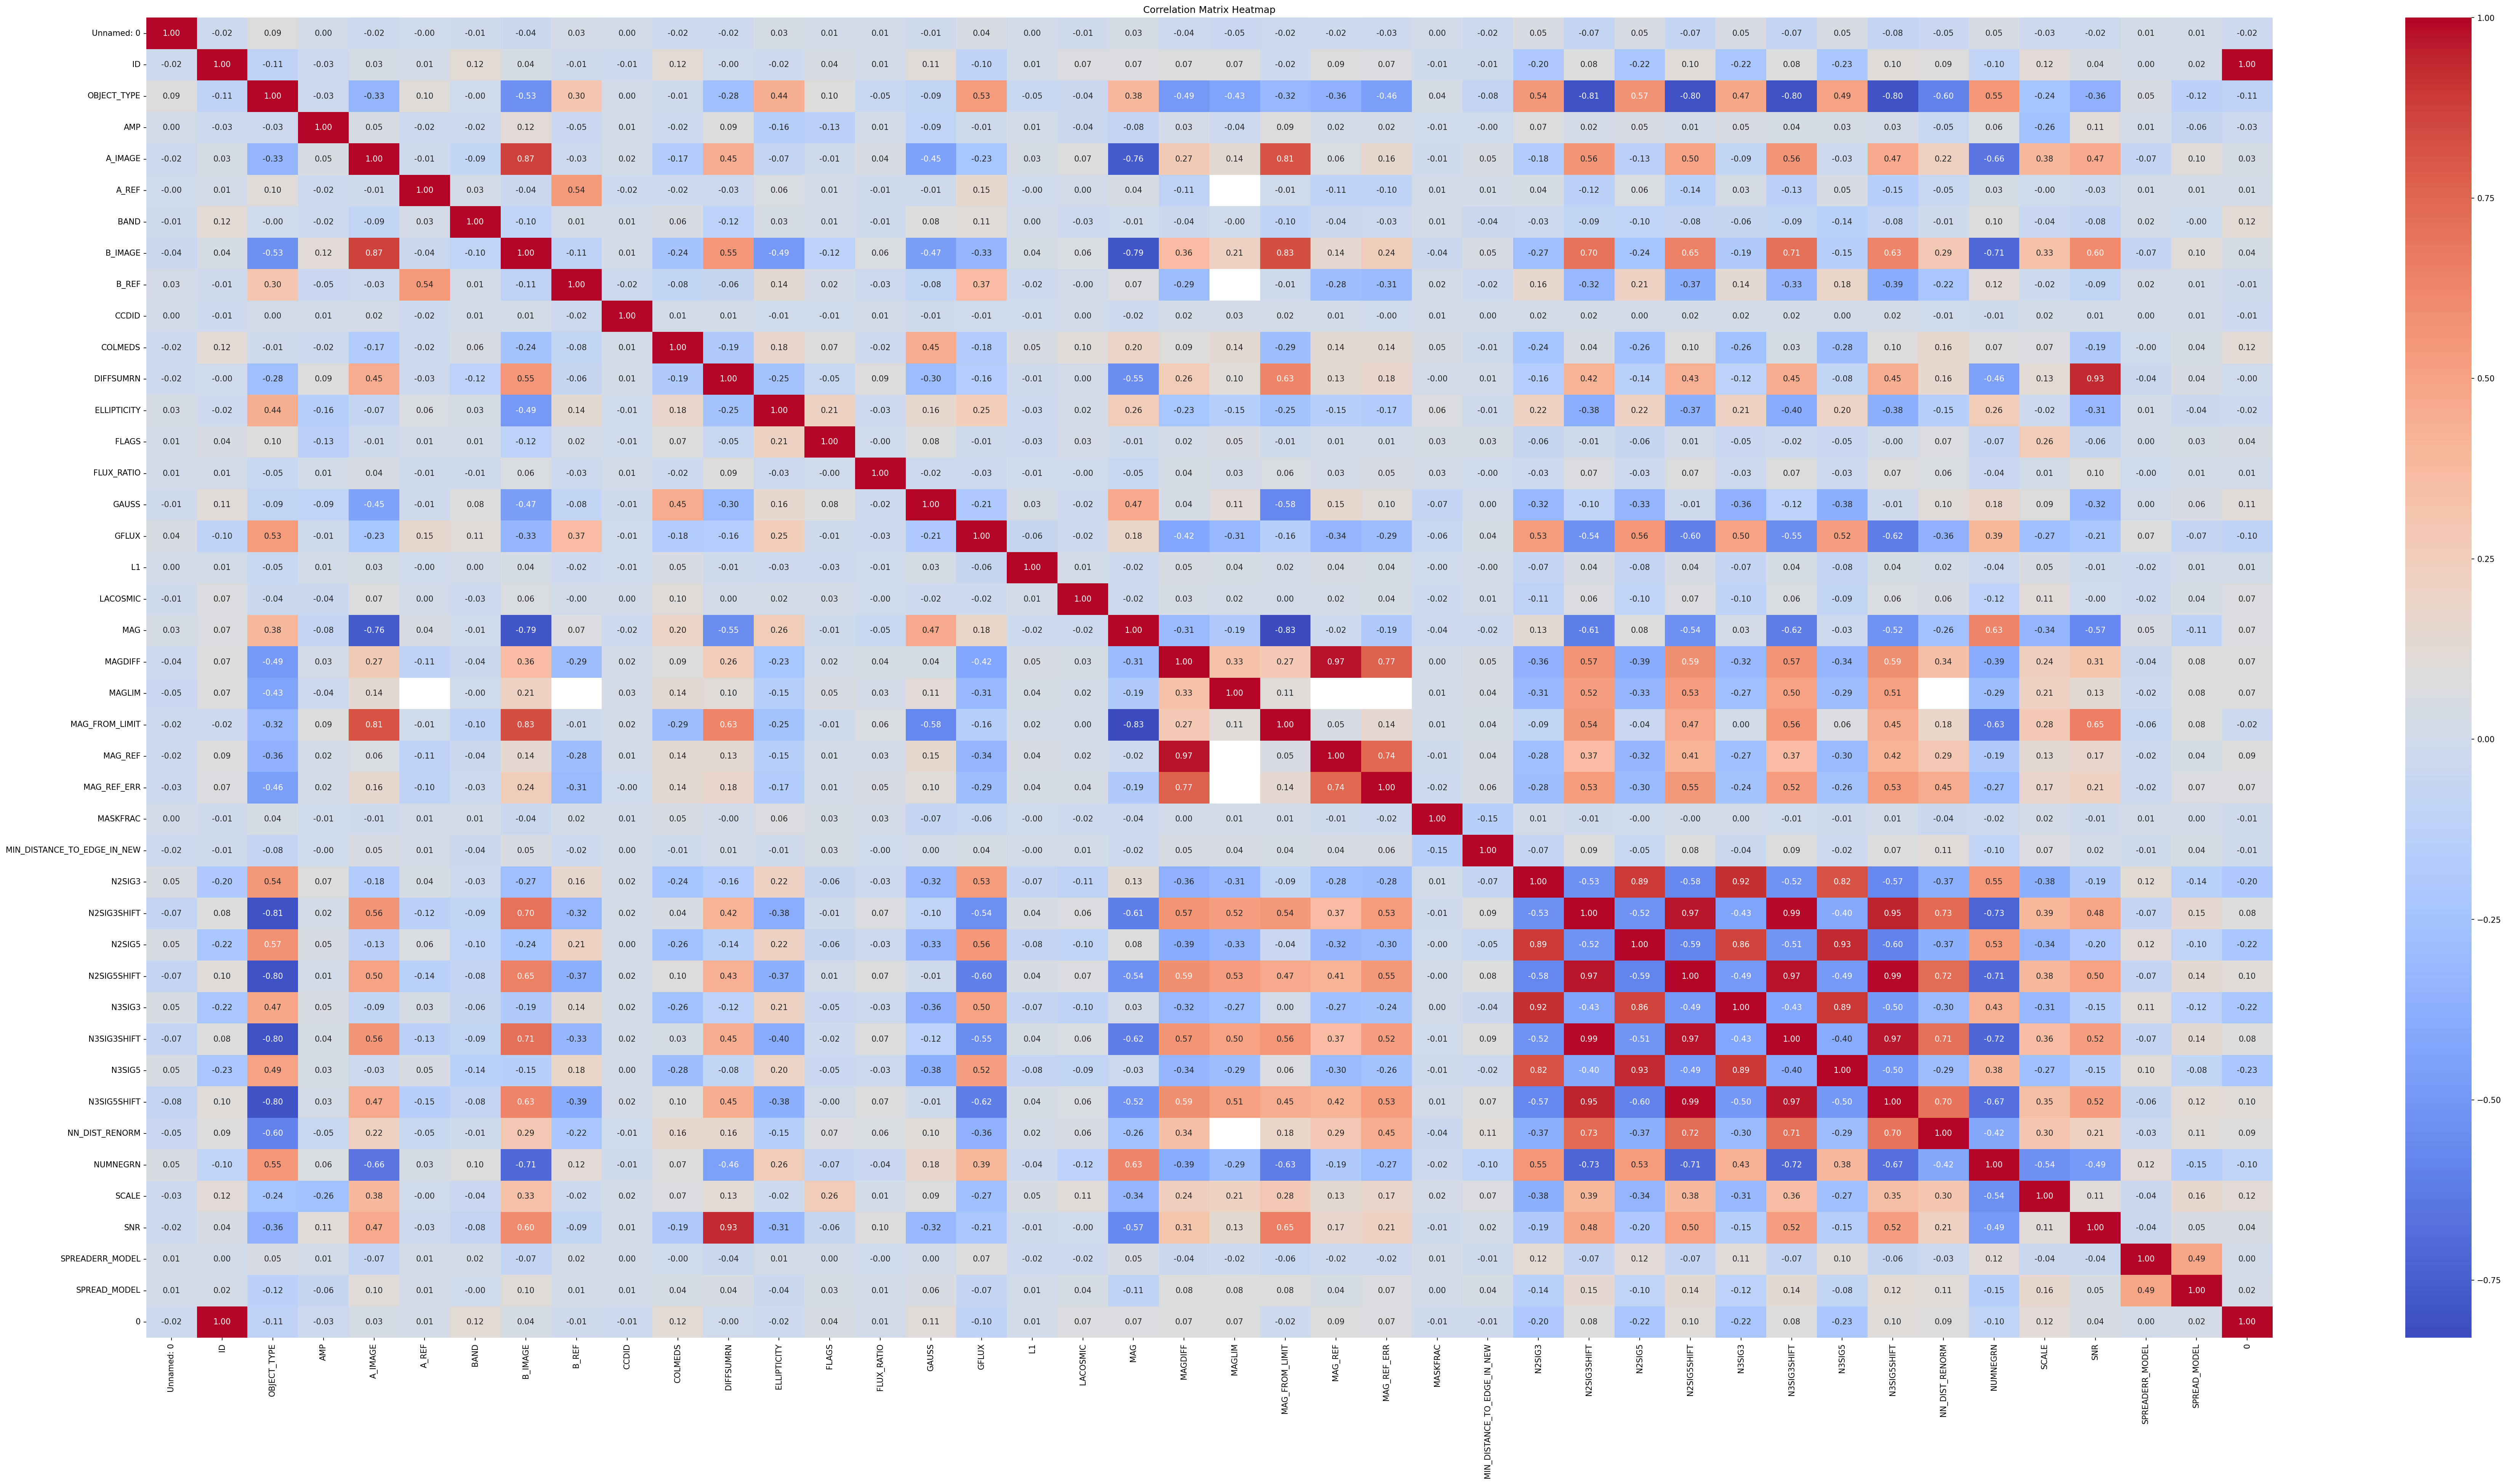

In [24]:
#print(y_data.corr())
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix =  y_data.corr()
plt.figure(figsize=(60, 30),dpi=150)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

##  Lidando com Features problemáticas:

In [25]:
# Verificando valores nulos no DataFrame
print("Resumo de valores nulos por coluna:")
print(features_test.isnull().sum())

# Exemplo 1: Remover linhas com valores nulos
# Útil quando queremos um subconjunto totalmente limpo dos dados.
filtered_df_dropna = features_test.dropna()
print("Dataset após remover linhas com valores nulos:")
print(filtered_df_dropna.shape)

# Exemplo 2: Remover colunas com valores nulos
# Quando preferimos eliminar colunas com dados incompletos.
filtered_df_dropna_cols = features_test.dropna(axis=1)
print("Dataset após remover colunas com valores nulos:")
print(filtered_df_dropna_cols.shape)

# Exemplo 3: Preencher valores nulos com um valor constante
# Aqui preenchemos valores nulos com zero (ou outro valor fixo de sua escolha).
filled_df_zero = features_test.fillna(0)
print("Dataset após preencher valores nulos com zero:")
print(filled_df_zero.head())

# Exemplo 4: Preencher valores nulos com a média de cada coluna
# Útil para substituir valores ausentes por estimativas baseadas nos dados existentes.
filled_df_mean = features_test.fillna(features_test.mean())
print("Dataset após preencher valores nulos com a média:")
print(filled_df_mean.head())

# Exemplo 5: Preencher valores nulos com a mediana de cada coluna
# Boa opção quando os dados possuem outliers, pois a mediana não é influenciada por eles.
filled_df_median = features_test.fillna(features_test.median())
print("Dataset após preencher valores nulos com a mediana:")
print(filled_df_median.head())


# Exemplo 6: Substituir valores nulos com base no valor anterior ou posterior
# Forward Fill (preenche com o valor da linha anterior)
filled_ffill_df = features_test.fillna(method='ffill')

# Backward Fill (preenche com o valor da linha seguinte)
filled_bfill_df = features_test.fillna(method='bfill')

print("Dataset após Forward Fill:")
print(filled_ffill_df.head())
print("Dataset após Backward Fill:")
print(filled_bfill_df.head())


Resumo de valores nulos por coluna:
AMP                               0
A_REF                          2290
BAND                              0
B_IMAGE                           0
B_REF                          2290
CCDID                             0
COLMEDS                           0
DIFFSUMRN                         0
ELLIPTICITY                       0
FLAGS                             0
FLUX_RATIO                        0
GAUSS                             0
L1                                0
LACOSMIC                          0
MAG                               0
MAGDIFF                           0
MAGLIM                            0
MAG_FROM_LIMIT                    0
MAG_REF                        2290
MAG_REF_ERR                    2290
MASKFRAC                          0
MIN_DISTANCE_TO_EDGE_IN_NEW       0
N2SIG3                            0
N2SIG3SHIFT                       0
N2SIG5                            0
N2SIG5SHIFT                       0
N3SIG3                      

/tmp/ipykernel_18299/2122547880.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_ffill_df = features_test.fillna(method='ffill')
/tmp/ipykernel_18299/2122547880.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_bfill_df = features_test.fillna(method='bfill')


<div style="color:red; font-weight:bold; font-size:20px;">
#### [Task] Escolha a melhor maneira para limpar os valores NAN e nulo do seu dataset e justifique:

In [26]:
'''

Faça seu código:


'''

'\n\nFaça seu código:\n\n\n'

In [27]:
# Filtrando o DataFrame para incluir apenas as linhas em que todas as colunas selecionadas não possuem valores nulos:
filtered_df = features_test[features_test[[ 'AMP', 'A_REF', 'BAND',
       'B_IMAGE', 'B_REF', 'CCDID', 'COLMEDS', 'DIFFSUMRN', 'ELLIPTICITY',
       'FLAGS', 'FLUX_RATIO', 'GAUSS', 'L1', 'LACOSMIC', 'MAG',
       'MAGDIFF', 'MAGLIM', 'MAG_FROM_LIMIT', 'MAG_REF', 'MAG_REF_ERR',
       'MASKFRAC', 'MIN_DISTANCE_TO_EDGE_IN_NEW', 'N2SIG3', 'N2SIG3SHIFT',
       'N2SIG5', 'N2SIG5SHIFT', 'N3SIG3', 'N3SIG3SHIFT', 'N3SIG5',
       'N3SIG5SHIFT', 'NN_DIST_RENORM', 'NUMNEGRN', 'SCALE', 'SNR',
       'SPREADERR_MODEL', 'SPREAD_MODEL']].notnull().all(1)]



In [28]:
mask=features_test[[ 'AMP', 'A_REF', 'BAND',
       'B_IMAGE', 'B_REF', 'CCDID', 'COLMEDS', 'DIFFSUMRN', 'ELLIPTICITY',
       'FLAGS', 'FLUX_RATIO', 'GAUSS', 'L1', 'LACOSMIC', 'MAG',
       'MAGDIFF', 'MAGLIM', 'MAG_FROM_LIMIT', 'MAG_REF', 'MAG_REF_ERR',
       'MASKFRAC', 'MIN_DISTANCE_TO_EDGE_IN_NEW', 'N2SIG3', 'N2SIG3SHIFT',
       'N2SIG5', 'N2SIG5SHIFT', 'N3SIG3', 'N3SIG3SHIFT', 'N3SIG5',
       'N3SIG5SHIFT', 'NN_DIST_RENORM', 'NUMNEGRN', 'SCALE', 'SNR',
       'SPREADERR_MODEL', 'SPREAD_MODEL']].notnull().all(1)

In [33]:
len(mask)

14907

In [29]:
# x_datafinal=x_data[mask]
# x_datafinal.shape

In [30]:
filtered_df

,AMP,A_REF,BAND,B_IMAGE,B_REF,CCDID,COLMEDS,DIFFSUMRN,ELLIPTICITY,FLAGS,...,N3SIG3,N3SIG3SHIFT,N3SIG5,N3SIG5SHIFT,NN_DIST_RENORM,NUMNEGRN,SCALE,SNR,SPREADERR_MODEL,SPREAD_MODEL
0,0.531837,2.555519,0,0.468,2.509721,52,0.049928,56.958462,0.507368,0,...,0,-10,3,-22,0.924680,15,2.083950,4.708784,0.004655,-0.002805
1,0.495848,5.897173,0,0.289,4.086975,52,0.113290,31.114668,0.499133,0,...,1,-21,2,-42,0.619498,20,2.143211,4.152969,0.005290,0.004733
2,1.006386,2.699702,0,1.191,2.569838,52,0.040533,91.364334,0.372167,0,...,3,-10,8,-22,0.737011,18,1.807541,9.160797,0.003462,-0.019242
3,0.853074,2.627933,0,0.977,2.554036,28,0.041701,45.600044,0.188538,0,...,2,-10,4,-20,0.977689,19,1.538837,6.044542,0.004819,-0.016572
5,0.507786,2.620173,0,0.477,2.497219,1,0.051994,49.810280,0.530973,16,...,1,-13,4,-27,0.660168,19,2.005534,4.558379,0.005315,-0.009643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14902,0.763482,3.903739,1,0.902,2.656357,6,0.115951,15.674376,0.212227,0,...,0,-20,0,-43,0.556593,29,1.468949,5.596974,0.007175,-0.036013
14903,0.470567,6.948134,1,0.333,5.000814,44,0.091304,10.219183,0.423875,0,...,0,-24,1,-44,0.635657,23,1.668448,3.517759,0.009927,-0.021436
14904,0.740089,4.087810,1,1.159,2.496189,44,0.127140,37.730293,0.215301,0,...,0,-18,1,-37,0.133402,19,2.107939,8.828901,0.004344,-0.007316
14905,0.870918,3.152924,1,2.271,1.784108,47,0.042321,167.809174,0.101306,0,...,0,11,0,5,1.796943,2,2.345171,43.833141,0.000859,-0.000407


### Resizing the images [NOT GOING TO BE USED]:
---

In order to lower the number of features and with no lost of performance we can resize the image from **(12617,51,51,3)** to **(12617,25,25,3)**.

In [30]:
from skimage.transform import resize

In [53]:
x_datafinalresized = resize(x_datafinal, (12617,25,25,3))
x_imagem_only = resize(x_datafinal, (12617,25,25,3))

In [54]:
x_datafinalresized.shape

(12617, 25, 25, 3)

## Input Features :
***
Now for a random forest classifier each pixel is a feature, and our image has 3 channels.

So our input data will be (number of images(line),number of features(columns)). 

The number of features in the image is given by the number of pixels multiply by the number of channels, ---> 25x25x3 = 1875.

**More 36 filters from the pandas dataframe filtered_df**

    

<div style="color:red; font-weight:bold; font-size:20px;">
#### [Task]: Escolha o input para o seu modelo (Imagem ou Features ou Imagem+Features)

In [40]:
# Ajustando a forma (shape) dos dados para serem usados como entrada no modelo Random Forest
# O array original 'x_datafinalresized' possui forma (12617, 3, 25, 25) e está sendo reformatado para (12617, 3*25*25)
# Isso transforma os dados de 3 dimensões espaciais para uma única dimensão linear por amostra.
#x_datafinalresized= x_datafinalresized.reshape((12617, 3 * 25 * 25))

# Convertendo os dados de previsores (features) para o tipo float
# Isso é necessário, pois modelos como Random Forest requerem entradas numéricas em ponto flutuante.
# Selecionando as classes alvo (labels) para o treinamento do modelo
# Aqui, a coluna 'OBJECT_TYPE' do DataFrame 'y_data' é filtrada usando a máscara 'mask'
# para obter apenas os valores relevantes.
previsores = y_data['OBJECT_TYPE'][mask]
previsores = previsores.astype(float)

# Exibindo as formas (shapes) dos arrays ajustados
# 'x_datafinalresized.shape' é a nova forma dos dados ajustados para o modelo.
# 'previsores.shape' representa as dimensões das labels ou classes associadas.
# 'filtered_df.shape' mostra as dimensões do DataFrame com as features adicionais filtradas.
#print(x_datafinalresized.shape, previsores.shape, filtered_df.shape)

# Unindo todas as features de entrada
# O método np.concatenate() é usado para combinar os dados ajustados ('x_datafinalresized') 
# com o DataFrame filtrado ('filtered_df') ao longo do eixo das colunas (axis=-1).
# Isso resulta em um único array contendo todas as features de entrada para o modelo.
#x_data = np.concatenate((x_datafinalresized, filtered_df), axis=-1)
x_data =  filtered_df[['MAGDIFF','SPREADERR_MODEL','N2SIG3','N2SIG5','N3SIG3','N3SIG5','MAG_REF_ERR','SNR','COLMEDS',
                       'NN_DIST_RENORM','ELLIPTICITY','AMP','CCDID','MAG','B_IMAGE','MAG_REF','DIFFSUMRN','A_REF',
                       'MASKFRAC','MAGLIM','BAND','N3SIG3SHIFT']]


# Fim do pré-processamento.

In [41]:
print(x_data.shape,previsores.shape,filtered_df.shape)

(12617, 22) (12617,) (12617, 36)


---
___

# Notebook Tutorial - 02
    Já escolhido o formato do Input Data, vamos começar a classificação com um modelo simples de Random Forest:

In [42]:
print("Input Shape of the Random Forest Cassifier: (Num. of objects, Num. of features) = "+str(x_data.shape))

Input Shape of the Random Forest Cassifier: (Num. of objects, Num. of features) = (12617, 22)


## Dividing in Train(80%) and Test(20%).

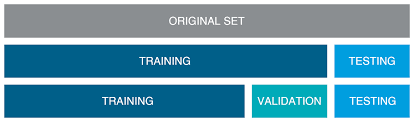

---

Now We need to split the data in train, test and validation. We can do this using sklearn library.

In [45]:
#Aqui você pode mudar para selecionar somente as images ou somente os features ou ambos
Random_forest = True
CNN_NN = False

if Random_forest:
    x_data_final_input = x_data        #selecionando o input para ser Imagem + features
if CNN_NN:
    x_data_final_input = x_imagem_only #selecionando o input para ser somente a imagem
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data_final_input,previsores, train_size=0.8,random_state=32)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((10093, 22), (10093,), (2524, 22), (2524,))

# Tuning Parameters 

In order to tune the hyperparameters from the randomForest classifier we need first do a Random Search on a large space of parameters and this search will helps us to narrow down the space parameters we need to cover.

---

## RandomGridSearch:

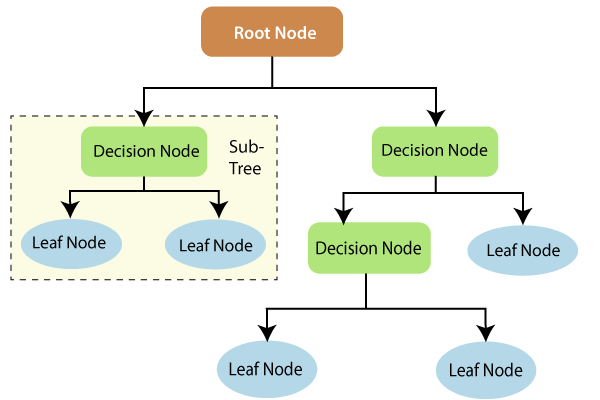

In [30]:
n_estimators = [10,50,100,300,800,1000,1500,5000]            # number of trees in the random forest
max_features = ['auto', 'sqrt']                              # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 3, 4, 10, 20, 50,70]                 # minimum sample number to split a node
min_samples_leaf = [1, 3, 4,10,20,50,70]                     # minimum sample number that can be stored in a leaf node
bootstrap = [True]                                           # method used to sample data points
criterion = ['gini','entropy','log_loss']

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [31]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
model=RandomForestClassifier()

In [32]:
#Using n_jobs = -1 will use all the cpus available
#random_state allows us to reproduce the results
#cv  = cross validation
#n_inter = interations_number
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = model,param_distributions = random_grid,
               n_iter = 200, cv = 10, verbose=2, random_state=35, n_jobs =-1)

In [ ]:
#Training the model:
model2 = rf_random.fit(X_train,y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


In [39]:
#Printing the best results basead on the randomsearchCV
from pprint import pprint
pprint(model2.best_estimator_.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [40]:
print('Best Parameters: ', rf_random.best_params_, ' \n')

Best Parameters:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}  



## GridSearch:

Now with the best possibles parameters we can run a GridSearchCV that search for the best combinations of parameters from all the combinations. Different of the RandomSearch that search only through some random combinations. 

In [29]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [30,40,50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,3, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1000,800,1200]
}
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
model=RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)
#cv = cross validation

In [30]:
model2 = grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


- **Best Parameters:**

In [32]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 800}

In [203]:
#best_gridmodel = grid_search.best_estimator_

## Cross validations:
Now with the best parameters defined, we can calculate the performance of our Random Forest Model using the Cross Validation:

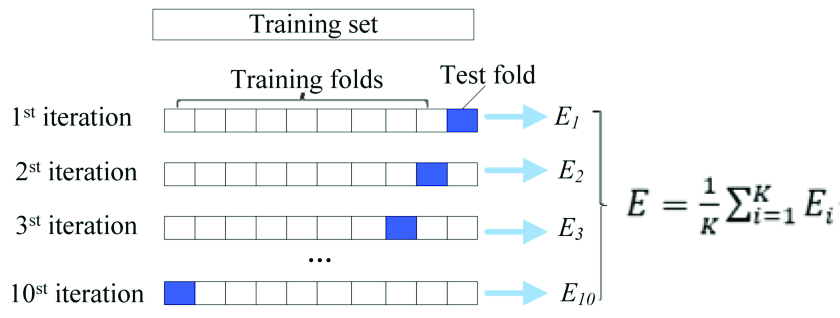

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=10):
    '''Function to perform 10 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=10
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.'''
    
    a_scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=a_scoring,
                               return_train_score=True)
      
    return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()}

**--> Inicialize the model with the best parameters:**

In [37]:
from sklearn.ensemble import RandomForestClassifier
'''
BEST:
 'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 800
 '''
#Create a Gaussian Classifier
model=RandomForestClassifier(n_estimators=800,
                             criterion='gini', max_depth=30, min_samples_split=12,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt',
                             max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,
                             oob_score=False, n_jobs=-1, random_state=69, verbose=2, warm_start=False,
                             class_weight=None, ccp_alpha=0.0, max_samples=None)

In [38]:
randomForest_result = cross_validation(model, X_train, y_train, 10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   13.1s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 456 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 456 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 456 tas

Printing the results of each traning fold

In [39]:
print(randomForest_result)

{'Training Accuracy scores': array([0.99520501, 0.9950093 , 0.99520501, 0.99452001, 0.99481358,
       0.99481409, 0.99559687, 0.99510763, 0.99530333, 0.99530333]), 'Mean Training Accuracy': 99.50878155862156, 'Training Precision scores': array([0.99385621, 0.99372631, 0.99398614, 0.99294855, 0.99333769,
       0.99346661, 0.99424761, 0.99372713, 0.99411611, 0.99411611]), 'Mean Training Precision': 0.9937528475939107, 'Training Recall scores': array([0.99973702, 0.99960557, 0.99960557, 0.99973705, 0.99973705,
       0.99960557, 0.99986852, 0.99973705, 0.99960557, 0.99960557]), 'Mean Training Recall': 0.9996844561795311, 'Training F1 scores': array([0.99678794, 0.99665727, 0.99678794, 0.99633124, 0.9965271 ,
       0.99652664, 0.99705015, 0.99672303, 0.99685328, 0.99685328]), 'Mean Training F1 Score': 0.9967097867759396, 'Validation Accuracy scores': array([0.94894366, 0.95950704, 0.96566901, 0.96126761, 0.95950704,
       0.95594714, 0.94273128, 0.96387665, 0.94449339, 0.95066079]), 'M

***
# Results:
***

In [161]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold","6th Fold","7th Fold","8th Fold","9th Fold","10th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='dodgerblue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='darkorange', label='Validation')
        plt.title(plot_title, fontsize=20)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.text(10, 0.7, 'Mean: '+ str(np.round(np.mean(val_data)*100,3))+'%'+'\n'+'Standard Deviation: '+ str(np.round(np.std(val_data)*100,3))+'%', fontsize =17,
             fontfamily='serif', 
             bbox = dict(facecolor = 'aliceblue', alpha = 0.7))
        plt.legend()
        plt.grid(True)
        plt.show()

## Metrics of each fold in Kfold Cross Validation

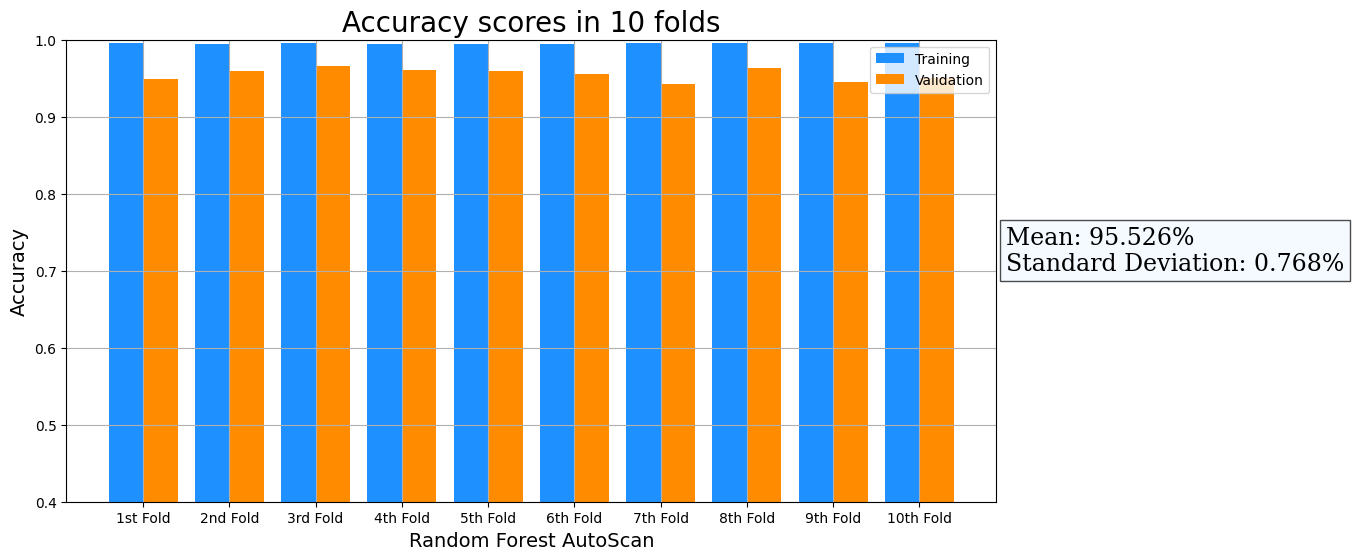

In [163]:
model_name = "Random Forest AutoScan"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 10 folds",
            randomForest_result["Training Accuracy scores"],randomForest_result["Validation Accuracy scores"])

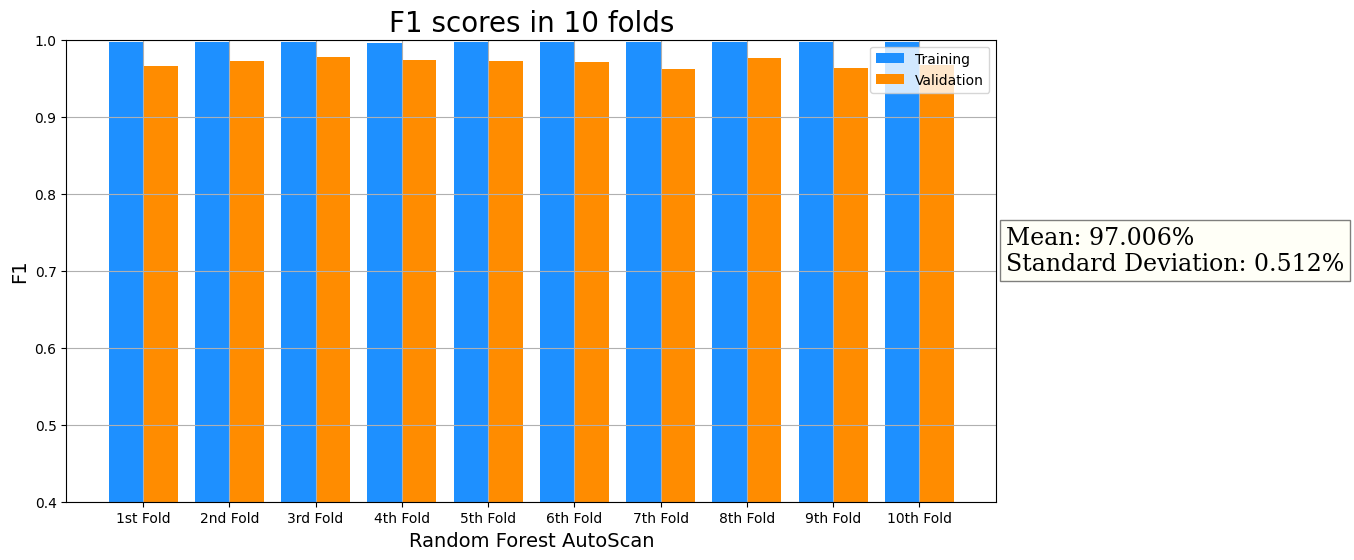

In [102]:
model_name = "Random Forest AutoScan"
plot_result(model_name,
            "F1",
            "F1 scores in 10 folds",
            randomForest_result["Training F1 scores"],
           randomForest_result["Validation F1 scores"])

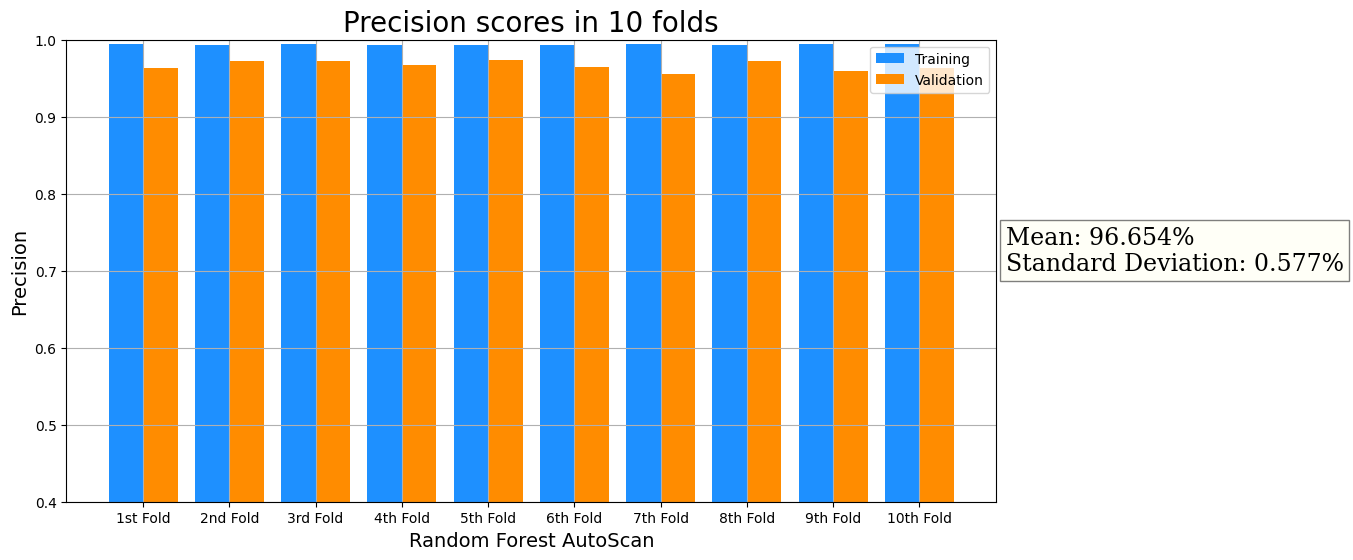

In [103]:
model_name = "Random Forest AutoScan"
plot_result(model_name,
            "Precision",
            "Precision scores in 10 folds",
            randomForest_result["Training Precision scores"],
           randomForest_result["Validation Precision scores"])

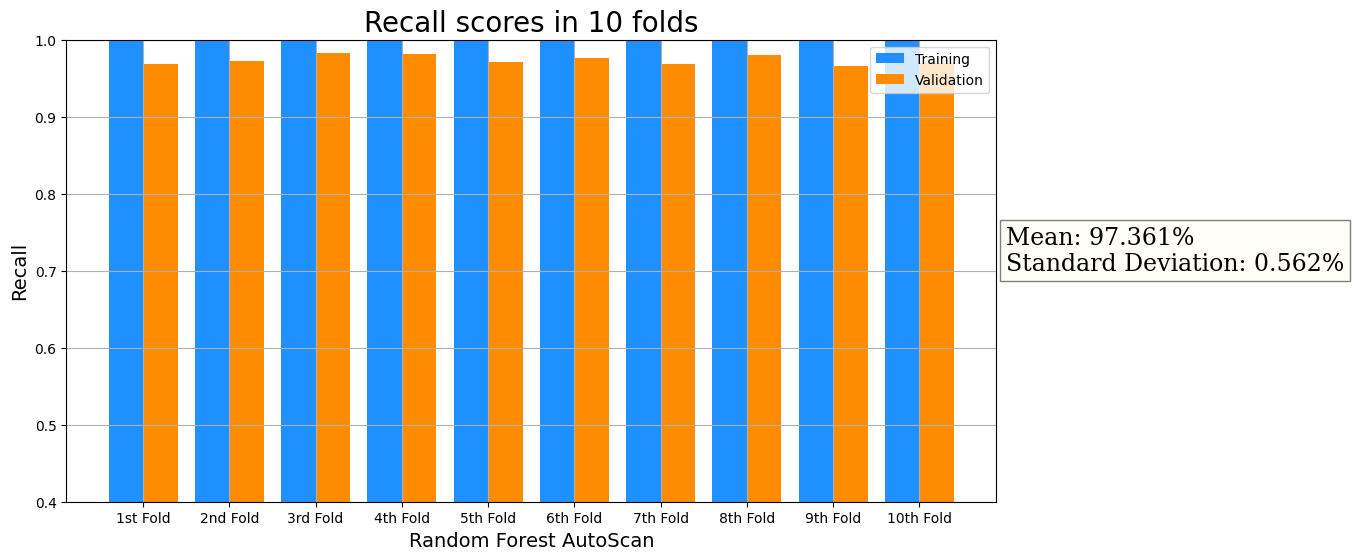

In [146]:
model_name = "Random Forest AutoScan"
plot_result(model_name,
            "Recall",
            "Recall scores in 10 folds",
            randomForest_result["Training Recall scores"],
           randomForest_result["Validation Recall scores"])

## Evaluating the model in the Test Dataset:

In [46]:
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 800building tree 2 of 800
building tree 3 of 800building tree 4 of 800
building tree 5 of 800


building tree 6 of 800building tree 7 of 800
building tree 8 of 800
building tree 9 of 800

building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800building tree 20 of 800

building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800building tree 32 of 800
building tree 33 of 800

building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800building tree 41 of 800
building tree 42 of 800

b

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    3.0s


building tree 278 of 800
building tree 279 of 800
building tree 280 of 800building tree 281 of 800building tree 282 of 800


building tree 283 of 800
building tree 284 of 800building tree 285 of 800

building tree 286 of 800
building tree 287 of 800
building tree 288 of 800building tree 289 of 800
building tree 290 of 800

building tree 291 of 800
building tree 292 of 800
building tree 293 of 800building tree 294 of 800

building tree 295 of 800building tree 296 of 800

building tree 297 of 800
building tree 298 of 800
building tree 299 of 800
building tree 300 of 800
building tree 301 of 800
building tree 302 of 800
building tree 303 of 800building tree 304 of 800building tree 305 of 800


building tree 306 of 800
building tree 307 of 800
building tree 308 of 800
building tree 309 of 800
building tree 310 of 800building tree 311 of 800

building tree 312 of 800
building tree 313 of 800building tree 314 of 800building tree 315 of 800


building tree 316 of 800
building tree 317 of 800b

[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    6.9s


building tree 561 of 800building tree 562 of 800

building tree 563 of 800
building tree 564 of 800
building tree 565 of 800
building tree 566 of 800
building tree 567 of 800
building tree 568 of 800
building tree 569 of 800building tree 570 of 800
building tree 571 of 800

building tree 572 of 800
building tree 573 of 800
building tree 574 of 800building tree 575 of 800

building tree 576 of 800building tree 577 of 800
building tree 578 of 800

building tree 579 of 800
building tree 580 of 800building tree 581 of 800

building tree 582 of 800
building tree 583 of 800building tree 584 of 800building tree 585 of 800


building tree 586 of 800
building tree 587 of 800building tree 588 of 800

building tree 589 of 800
building tree 590 of 800
building tree 591 of 800
building tree 592 of 800
building tree 593 of 800building tree 594 of 800

building tree 595 of 800
building tree 596 of 800
building tree 597 of 800
building tree 598 of 800
building tree 599 of 800building tree 600 of 800
b

[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   11.7s finished


RandomForestClassifier(max_depth=30, min_samples_split=12, n_estimators=800,
                       n_jobs=-1, random_state=69, verbose=2)

In [47]:
#Predicting the model basead on the X_test
y_actu1 = pd.DataFrame(y_test)
y_pred1 = model.predict(X_test)
y_actu1=y_actu1['OBJECT_TYPE']

[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 456 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 800 out of 800 | elapsed:    0.4s finished


---
### Plot Functions

In [50]:
def plot_metrics(X_1,y_1,classificador1):
    '''
    input:
    
    -<array>- y_1 = List of the real label
    
    -<array>- X_1 = Images
    
    -<model>- classificador1 = model already trained


    Output:
    
    Displays the two main plots in a Binary Classification:
    
    
    1) The Roc Curve: Summarize the trade-off between the true positive rate and false positive rate for a predictive model using 
    different probability thresholds.
    ideally whe would like to have 1.0 of true positive rate and 0.0 of False negative rate.
    
    The AUC(area under the curve) simplifies the plot in a single number, 
    if the neural network misclassified all the data, the AUC is zero, and if the NN classifies all the images correctly the AUC is 1.0 (one).

    
    2) Precision-Recall Curve: Summarize the trade-off between the true positive rate and 
    the positive predictive value for a predictive model using different probability thresholds.
    
    
    The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
    fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

    The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
    The recall is intuitively the ability of the classifier to find all the positive samples.
    
    
    '''
    y_predict = classificador1.predict(X_1)
    y_actu = y_1
 
    #--------- ROC Curve -------------------------------------------------------------------------------------------------------
    from sklearn.metrics import roc_curve
    y_pred_keras = classificador1.predict(X_1).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve( y_actu, y_pred_keras)
    from sklearn.metrics import auc
    
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(figsize = (6,5),dpi=100)
    plt.plot([0.0,0.0,1.0], [0.0,1.0,1.0], label='Perfect Performance (AUC = 1.0)', ls=':', zorder=10, lw=1.0,c='Green')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    
    plt.plot(fpr_keras, tpr_keras, label='Classifier (area = {:.3f})'.format(auc_keras))
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show() 
    #-------------- Precision-Recall Curve -----------------------------------------------------------------------------------
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    plt.figure(figsize = (6,5),dpi=100)
    precision, recall, thresholds = precision_recall_curve(y_actu,y_predict)
    lr_precision, lr_recall, _ = precision_recall_curve(y_actu,y_predict)

    aucski = auc(recall, precision)
    no_skill = len(y_actu[y_actu==1]) / len(y_actu)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier (area = {:.2f})'.format(aucski))
    # axis labels
    plt.title('Precision x Recall curve')
    0
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
    #------------------------------------------------------------------------------

In [201]:
def matrix_confu(y_actua,y_preda):
    '''
    **Create a Confusion Matrix basead in 
    a Binary Classification**
    
    -<array>- y_actua = List of the real classification
    
    -<array>- y_preda = List of the values predited by the model
    
    Output: Confusion Matrix and Binary classification metrics
    
    Metrics:
    
    - Precision: tp / (tp + fp)
    The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    
    - Recall: tp / (tp + fn)
    The recall is intuitively the ability of the classifier to find all the positive samples.
    
    - F1-score: 2* (Precision * Recall) / (Precision + Recall)
    The goal of the F1 score is to combine the precision and recall metrics into a single metric.

    - Accuracy: (tp + tn) / (tp + fn + fp+ tn)
    The Accuracy is the percentage of correct labels with respect to the total
    
    
    
    
    '''
    import seaborn as sns
    df_confusion = np.array(pd.crosstab(y_actua, y_preda, rownames=['Real'], colnames=['predicted']),dtype=np.float64)
    df_confusion_percent = np.zeros((2,2))
    df_confusion_percent[0,0]=df_confusion[0][0]/y_actua.value_counts()[0]
    df_confusion_percent[0,1]=df_confusion[0][1]/y_actua.value_counts()[0]
    df_confusion_percent[1,0]=df_confusion[1][0]/y_actua.value_counts()[1]
    df_confusion_percent[1,1]=df_confusion[1][1]/y_actua.value_counts()[1]
    x_axis_label=['Real Artifact','Real Transient',]
    y_axis_label=['Predicted Artifact ','Predicted Transient ']
    tn1 = round(np.float64((df_confusion[0][0]/(df_confusion[0][0]+df_confusion[0][1]))), 3)

    tp1 = round(np.float64((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[1][0])), 3)

    fn1 = round(np.float64(df_confusion[1][0]/(df_confusion[1][0]+df_confusion[1][1])), 3)

    fp1 = round(np.float64(df_confusion[0][1]/(df_confusion[0][1]+df_confusion[0][0])), 3)
       #----------------------------------------------------------------------------------------------------------------------

    
    acuracia = ((df_confusion[1][1]+df_confusion[0][0])/(df_confusion[1][1]+df_confusion[0][0]+df_confusion[1][0]+df_confusion[0][1]))*100
    precisao=float((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[0][1]))*100
    recall=float((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[1][0]))*100

    f1= 2*(precisao*recall)/(precisao+recall) 
   
    from sklearn.metrics import f1_score   



    porcentagens = [str(int(tn1*100000)/1000)+'%',str(int(fn1*100000)/1000)+'%',str(int(fp1*100000)/1000)+'%',str(int(tp1*100000)/1000)+'%']
    entradas = [int(df_confusion[0,0]),int(df_confusion[1,0]),int(df_confusion[0,1]),int(df_confusion[1,1])]
    labels = [f'{numero} \n{porc}' for numero, porc in zip(entradas,porcentagens)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (6,5),dpi=110)
    sns.heatmap(df_confusion_percent,square=True,
                 cmap="BuGn", annot=labels, cbar=False,fmt='',xticklabels=x_axis_label, yticklabels=y_axis_label,linewidths=1.6, linecolor='black', annot_kws={'fontsize':16,'fontfamily':'serif'})

    plt.text(2.2, 1, 'Recall: '+ str(np.round(recall,2))+'%'+'\n'+'Precision:'+ str(np.round(precisao,2))+'%'+'\n'+ 'F1-score:'+ str(np.round(f1,2))+'%'+'\n'+'Accuracy:'+str(np.round(acuracia,2))+'%', fontsize =15,
             fontfamily='serif', 
             bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
    plt.show()


## Confusion Matrix:

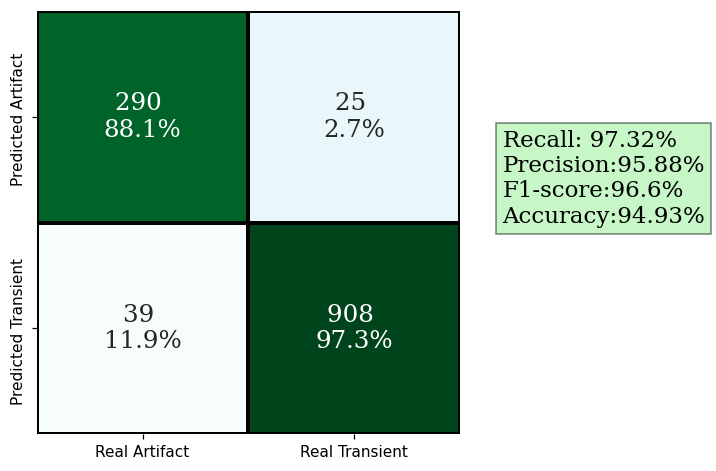

In [202]:
matrix_confu(y_actu1,y_pred1)

### Roc curve and Precision x Recall curve:

[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 456 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 456 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 800 out of 800 | elapsed:    0.4s finished


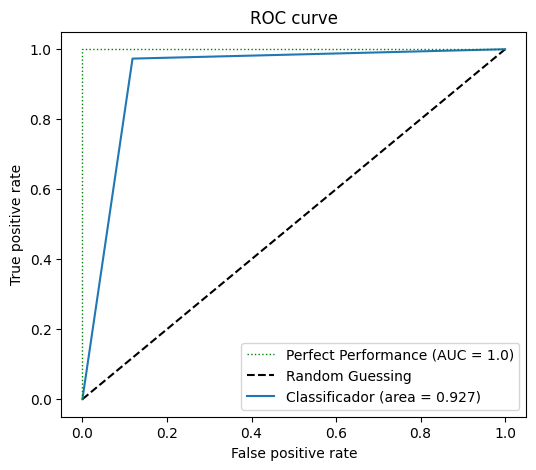

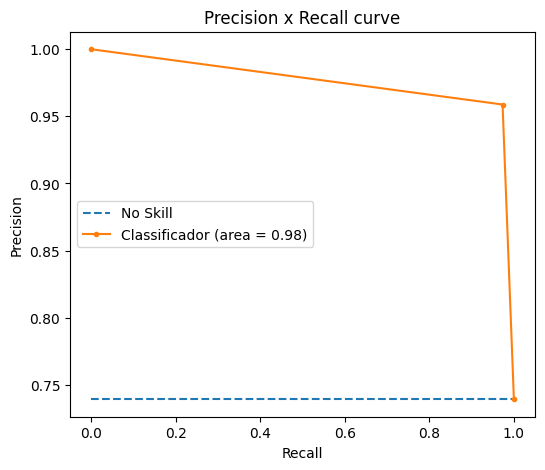

In [54]:
plot_metrics(X_test,y_test,model)

# Modelo simples usando Tensorflow e CNNs

In [69]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definindo o modelo de CNN
def create_cnn_model(input_shape=(25, 25, 3)):
    model = models.Sequential()

    # Primeira camada de convolução e pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Segunda camada de convolução e pooling
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Terceira camada de convolução
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Achatar a saída para conectá-la às camadas densas
    model.add(layers.Flatten())
    #Camada de Droupout:
    model.add(layers.Dropout(0.5))
    # Camada totalmente conectada
    model.add(layers.Dense(128, activation='relu'))

    # Camada de saída com uma única unidade (classificação binária)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Criando o modelo
input_shape = (25, 25, 3)
cnn_model = create_cnn_model(input_shape)

# Compilando o modelo
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','precision','recall']
)

# Exibindo o resumo do modelo
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,345 (349.00 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Treinando o modelo
history = cnn_model.fit(X_train, y_train,
    epochs=30,  # Número de épocas
    batch_size=128,  # Tamanho do batch
    validation_split=0.20,  # Dados de validação
    verbose=1
)


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7427 - loss: 0.5923 - precision: 0.7461 - recall: 0.9932 - val_accuracy: 0.7306 - val_loss: 0.5806 - val_precision: 0.7306 - val_recall: 1.0000
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7414 - loss: 0.5709 - precision: 0.7414 - recall: 1.0000 - val_accuracy: 0.7306 - val_loss: 0.5828 - val_precision: 0.7306 - val_recall: 1.0000
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7369 - loss: 0.5760 - precision: 0.7369 - recall: 1.0000 - val_accuracy: 0.7306 - val_loss: 0.5780 - val_precision: 0.7306 - val_recall: 1.0000
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7485 - loss: 0.5575 - precision: 0.7485 - recall: 1.0000 - val_accuracy: 0.7306 - val_loss: 0.5770 - val_precision: 0.7306 - val_recall: 1.0000
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7473 - loss: 0.5572 - precision: 0.7473 - recall: 1.0000 - val_accuracy: 0.7306 - val_loss: 0.5786 

<div style="color:red; font-weight:bold; font-size:20px;">
#### [Task] Veja como o valor da Loss do Treino e de Validação mudam conforme o tempo.

- O que acontece quando o batch_size é muito grande ou muito pequeno?
- A Rede está apresentando overfitting ou underfitting?
- Melhorar a arquitetura da rede para resultados melhores
- Fazer a rede mais profunda melhorou o resultado?

In [71]:
'''

Faça Seu código:


'''

'\n\nFaça Seu código:\n\n\n'

<div style="color:red; font-weight:bold; font-size:20px;">
#### [Task] Compare os seus resultados para diferentes Algoritmos de Machine Learning e arquiteturas:
</div>

In [72]:
'''

Faça seu código:

'''

'\n\nFaça seu código:\n\n'

# MODELO SIMPLES CORRIGIDO - SOMENTE DADO TABULARES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
if Random_forest:
    x_data_final_input = x_data        #selecionando o input para ser Imagem + features
if CNN_NN:
    x_data_final_input = x_imagem_only #selecionando o input para ser somente a imagem
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data_final_input,previsores, train_size=0.8,random_state=32)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

In [ ]:
#CRIANDO UM MODELO SIMPLES DE BASE
model = keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])




#Callbacks = []
#Earlystopping
#learningratescheduler

# Treinando o modelo
history = model.fit(X_train, y_train,
    epochs=30,  # Número de épocas
    batch_size=128,  # Tamanho do batch
    validation_split=0.20,  # Dados de validação
    verbose=1
)


In [ ]:
# Evaluate the model on validation set
test_results = model.evaluate(X_test, y_test)
print(f"Validation Loss: {test_results[0]:.4f}, Validation Accuracy: {test_results[1]:.4f}")

# [EXTRA]:

In [ ]:
# Split input into two separate feature sets
X1_train = X_train[:, :11]  # First half of features
X2_train = X_train[:, 11:]  # Second half of features

# Define two separate input layers
input1 = keras.Input(shape=(11,))
input2 = keras.Input(shape=(11,))

# Define separate neural networks for each input
x1 = layers.Dense(128, activation='relu')(input1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dropout(0.3)(x1)
x1 = layers.Dense(64, activation='relu')(x1)

x2 = layers.Dense(128, activation='relu')(input2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.3)(x2)
x2 = layers.Dense(64, activation='relu')(x2)

# Concatenate both network outputs
merged = layers.concatenate([x1, x2])
merged = layers.Dense(32, activation='relu')(merged)
merged = layers.BatchNormalization()(merged)
merged = layers.Dropout(0.3)(merged)
merged = layers.Dense(16, activation='relu')(merged)
out = layers.Dense(1, activation='sigmoid')(merged)

# Define the model
model = keras.Model(inputs=[input1, input2], outputs=out)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    [X1_train, X2_train], y_train,
    epochs=50,
    batch_size=64,
    verbose=1
)